# ML model Training (Question 3 of the Homework)

In [24]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

custom_style = {"grid.color": "black", "grid.linestyle": ":", "grid.linewidth": 0.3, "axes.edgecolor": "black", "ytick.left": True, "xtick.bottom": True}
sns.set_context("notebook")
sns.set_theme(style="whitegrid", rc=custom_style)

In [3]:
# Read datasets

df_pe = pd.read_csv("../data/pe/cleaned/pe_dataset.csv")
normalized_df_pe = pd.read_csv("../data/pe/cleaned/normalized_pe_dataset.csv")
normalized_df_pe_without_outliers = pd.read_csv("../data/pe/cleaned/normalized_pe_dataset_without_outliers.csv")

In [4]:
def splitDataset(df, test_size=0.15, should_have_validation_set=True):
    from sklearn.model_selection import train_test_split
    X = df.drop(columns=['Entity', 'Year','Primary energy consumption per capita (kWh/person)'])
    y = df['Primary energy consumption per capita (kWh/person)']
    X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=None)

    if should_have_validation_set:
        X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size=test_size/(1-test_size), shuffle=True, random_state=None)
        print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)
        return X_train, X_test, X_val, y_train, y_test, y_val
    
    print(X_pretrain.shape, X_test.shape, y_pretrain.shape, y_test.shape)
    return X_pretrain, X_test, y_pretrain, y_test

## Linear Regression

As seen in the [ML algorithm selection notebook](ML_algorithm_selection.ipynb), the linear model does not have any hyperparameters to tune. Therefore, cross-validation is not required. We can split our datasets into training, testing and validation sets like so:

- Training set: 80%
- Testing set: 20%

To do that, I'll use the `train_test_split` function from `sklearn.model_selection` module. This function provides parameters to shuffle or not our dataset before splitting it. I'll set the `shuffle` parameter to `True` to ensure that the data is shuffled before splitting it. According to [scikit-learn documentation](https://scikit-learn.org/stable/glossary.html#term-random_state), by default the function will use the global random state from `np.random` module to shuffle the data. 

NOTE: I don't see the use here of having reproducible results, so I'll leave the `random_state` parameter to `None`. 

In [5]:
# Split datasets into train, test and validation sets
X_pe_train, X_pe_test, y_pe_train, y_pe_test = splitDataset(df_pe, test_size=0.2, should_have_validation_set=False)

# nor -> normalized
X_nor_pe_train, X_nor_pe_test, y_nor_pe_train, y_nor_pe_test = splitDataset(normalized_df_pe, test_size=0.2, should_have_validation_set=False)

# nor_wo -> normalized without outliers
X_nor_pe_wo_train, X_nor_pe_wo_test, y_nor_pe_wo_train, y_nor_pe_wo_test = splitDataset(normalized_df_pe_without_outliers, test_size=0.2, should_have_validation_set=False)


(2554, 4) (639, 4) (2554,) (639,)
(2554, 4) (639, 4) (2554,) (639,)
(2407, 4) (602, 4) (2407,) (602,)


Once we have our subsets, we can train our model using the training set for each dataset.

In [6]:
# Model training

from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model_nor = LinearRegression()
LR_model_nor_wo = LinearRegression()

In [7]:
# Train on global dataset

LR_model.fit(X_pe_train, y_pe_train)
print(f'R^2 score: {LR_model.score(X_pe_train, y_pe_train).round(3)}')
LR_coef = pd.DataFrame(LR_model.coef_, index=X_pe_train.columns, columns=['Coefficient'])
LR_coef.loc['Intercept'] = LR_model.intercept_
LR_coef.round(3)

R^2 score: 0.539


,Coefficient
Access to electricity (% of population),-89.994
Access to clean fuels for cooking,214.417
Renewable energy share in the total final energy consumption (%),-139.134
gdp_per_capita,1.164
Intercept,10403.006


In [8]:
# Train on normalized dataset

LR_model_nor.fit(X_nor_pe_train, y_nor_pe_train)
print(f'R^2 score: {LR_model_nor.score(X_nor_pe_train, y_nor_pe_train).round(3)}')
LR_coef_nor = pd.DataFrame(LR_model_nor.coef_, index=X_nor_pe_train.columns, columns=['Coefficient'])
LR_coef_nor.loc['Intercept'] = LR_model_nor.intercept_
LR_coef_nor.round(3)

R^2 score: 0.54


,Coefficient
Access to electricity (% of population),-0.034
Access to clean fuels for cooking,0.082
Renewable energy share in the total final energy consumption (%),-0.052
gdp_per_capita,0.519
Intercept,0.041


In [9]:
# Train on normalized dataset without outliers

LR_model_nor_wo.fit(X_nor_pe_wo_train, y_nor_pe_wo_train)
print(f'R^2 score: {LR_model_nor_wo.score(X_nor_pe_wo_train, y_nor_pe_wo_train).round(3)}')
LR_coef_nor_wo = pd.DataFrame(LR_model_nor_wo.coef_, index=X_nor_pe_wo_train.columns, columns=['Coefficient'])
LR_coef_nor_wo.loc['Intercept'] = LR_model_nor_wo.intercept_
LR_coef_nor_wo.round(3)

R^2 score: 0.699


,Coefficient
Access to electricity (% of population),-0.039
Access to clean fuels for cooking,0.172
Renewable energy share in the total final energy consumption (%),-0.098
gdp_per_capita,0.839
Intercept,0.074


## Elastic Net

As seen in the [ML algorithm selection notebook](ML_algorithm_selection.ipynb), the Elastic Net model do have 2 hyperparameters to tune. Therefore, we can use cross-validation to find the best combination of hyperparameters. The following procedure is followed for each of the k folds:

- A model is trained using k-1 of the folds as training data;
- The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

![k-fold cross-validation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)


The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop

The scikit-learn library provides a built-in version of the Elastic Net algorithm that automatically finds good hyperparameters using cross-validation: [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV).

So, to use this model, we need to set:

- An array of $\alpha$ values to test;
- An array of $l1_{ratio}$ values to test; According to scikit-learn documentation on this model:

    > A good choice of list of values for l1_ratio is often to put more values close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge), as in [.1, .5, .7, .9, .95, .99, 1].
- The number of folds to use for cross-validation. (k = 10 is a good default value).

In [10]:
# Model training

from sklearn.linear_model import ElasticNetCV

l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

EN_model = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=10)
EN_model_nor = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=10)
EN_model_nor_wo = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=10)

In [11]:
# Train on global dataset

X_pe_train, X_pe_test, y_pe_train, y_pe_test = splitDataset(df_pe, test_size=0.2, should_have_validation_set=False)

EN_model.fit(X_pe_train, y_pe_train)

print(f'alpha: {EN_model.alpha_}')
print(f'l1_ratio: {EN_model.l1_ratio_}')
print(f'R^2 score: {EN_model.score(X_pe_train, y_pe_train).round(3)}')

EN_model_coef = pd.DataFrame(EN_model.coef_, index=X_pe_train.columns, columns=['Coefficient'])
EN_model_coef.loc['Intercept'] = EN_model.intercept_
EN_model_coef.round(3)

(2554, 4) (639, 4) (2554,) (639,)


alpha: 10.0
l1_ratio: 0.1
R^2 score: 0.547


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1102472664.0583496, tolerance: 312800345.0532134
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 958137466.9204102, tolerance: 313731707.55899036
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4202788372.876465, tolerance: 307539530.97148395
  model = cd_fast.enet_coordinate_

,Coefficient
Access to electricity (% of population),-70.147
Access to clean fuels for cooking,203.707
Renewable energy share in the total final energy consumption (%),-118.732
gdp_per_capita,1.179
Intercept,8442.170


In [12]:
# Train on normalized dataset

X_nor_pe_train, X_nor_pe_test, y_nor_pe_train, y_nor_pe_test = splitDataset(normalized_df_pe, test_size=0.2, should_have_validation_set=False)

EN_model_nor.fit(X_nor_pe_train, y_nor_pe_train)

print(f'alpha: {EN_model_nor.alpha_}')
print(f'l1_ratio: {EN_model_nor.l1_ratio_}')
print(f'R^2 score: {EN_model_nor.score(X_nor_pe_train, y_nor_pe_train).round(3)}')

EN_model_nor_coef = pd.DataFrame(EN_model_nor.coef_, index=X_nor_pe_train.columns, columns=['Coefficient'])
EN_model_nor_coef.loc['Intercept'] = EN_model_nor.intercept_
EN_model_nor_coef.round(3)

(2554, 4) (639, 4) (2554,) (639,)
alpha: 0.0001
l1_ratio: 0.1
R^2 score: 0.539


,Coefficient
Access to electricity (% of population),-0.030
Access to clean fuels for cooking,0.080
Renewable energy share in the total final energy consumption (%),-0.050
gdp_per_capita,0.523
Intercept,0.038


In [13]:
# Train on normalized dataset without outliers

X_nor_pe_wo_train, X_nor_pe_wo_test, y_nor_pe_wo_train, y_nor_pe_wo_test = splitDataset(normalized_df_pe_without_outliers, test_size=0.2, should_have_validation_set=False)

EN_model_nor_wo.fit(X_nor_pe_wo_train, y_nor_pe_wo_train)

print(f'alpha: {EN_model_nor_wo.alpha_}')
print(f'l1_ratio: {EN_model_nor_wo.l1_ratio_}')
print(f'R^2 score: {EN_model_nor_wo.score(X_nor_pe_wo_train, y_nor_pe_wo_train).round(3)}')

EN_model_nor_wo_coef = pd.DataFrame(EN_model_nor_wo.coef_, index=X_nor_pe_wo_train.columns, columns=['Coefficient'])
EN_model_nor_wo_coef.loc['Intercept'] = EN_model_nor_wo.intercept_
EN_model_nor_wo_coef.round(3)

(2407, 4) (602, 4) (2407,) (602,)


alpha: 1e-05
l1_ratio: 0.5
R^2 score: 0.705


,Coefficient
Access to electricity (% of population),-0.032
Access to clean fuels for cooking,0.169
Renewable energy share in the total final energy consumption (%),-0.089
gdp_per_capita,0.837
Intercept,0.066


## Linear SVR

As seen in the [ML algorithm selection notebook](ML_algorithm_selection.ipynb), the Elastic Net model do have 4 hyperparameters to tune. However, is those 4 hyperparameters, only 1 remains ($c$ hyperparameter) totally unknown for us. Other hyperparameters are known:

- The loss function: `epsilon_insensitive` because we want to use standard Support Vector Regression;
    - $\epsilon$ value for the loss function: 0; According to the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html): 
        > the value of this parameter depends on the scale of the target variable y. If unsure, set $\epsilon$=0.

- $tol$ value: 1e-4 (scikit-learn default value);


Thus we can still perform cross-validation to find the best $c$ value. 

In [14]:
# Model training

from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [10**i for i in range(-6, 1)]}

base_LSVR_model = LinearSVR(loss='epsilon_insensitive', epsilon=0, max_iter=10_000)

LSVR_model = GridSearchCV(base_LSVR_model, param_grid, cv=10, scoring='r2')
LSVR_model_nor = GridSearchCV(base_LSVR_model, param_grid, cv=10, scoring='r2')
LSVR_model_nor_wo = GridSearchCV(base_LSVR_model, param_grid, cv=10, scoring='r2')

In [15]:
# Train on global dataset

X_pe_train, X_pe_test, y_pe_train, y_pe_test = splitDataset(df_pe, test_size=0.2, should_have_validation_set=False)

LSVR_model.fit(X_pe_train, y_pe_train)

print(f'C: {LSVR_model.best_params_}')

(2554, 4) (639, 4) (2554,) (639,)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the numb

C: {'C': 0.01}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


For the global dataset it seam that the algorithm is not able to converge. After some research, the problem seams to be the scale of the data. So, it might work better on my normalized datasets.

In [16]:
# Train on normalized dataset

X_nor_pe_train, X_nor_pe_test, y_nor_pe_train, y_nor_pe_test = splitDataset(normalized_df_pe, test_size=0.2, should_have_validation_set=False)

LSVR_model_nor.fit(X_nor_pe_train, y_nor_pe_train)

print(LSVR_model_nor.best_params_)

print(f'R^2 score: {LSVR_model_nor.score(X_nor_pe_train, y_nor_pe_train).round(3)}')

LSVR_model_nor_coef = pd.DataFrame(LSVR_model_nor.best_estimator_.coef_, index=X_nor_pe_train.columns, columns=['Coefficient'])
LSVR_model_nor_coef.loc['Intercept'] = LSVR_model_nor.best_estimator_.intercept_
LSVR_model_nor_coef.round(3)

(2554, 4) (639, 4) (2554,) (639,)
{'C': 1}
R^2 score: 0.503


,Coefficient
Access to electricity (% of population),-0.007
Access to clean fuels for cooking,0.035
Renewable energy share in the total final energy consumption (%),-0.015
gdp_per_capita,0.517
Intercept,0.014


In [17]:
# Train on normalized dataset without outliers

X_nor_pe_wo_train, X_nor_pe_wo_test, y_nor_pe_wo_train, y_nor_pe_wo_test = splitDataset(normalized_df_pe_without_outliers, test_size=0.2, should_have_validation_set=False)

LSVR_model_nor_wo.fit(X_nor_pe_wo_train, y_nor_pe_wo_train)

print(LSVR_model_nor_wo.best_params_)
print(f'R^2 score: {LSVR_model_nor_wo.score(X_nor_pe_wo_train, y_nor_pe_wo_train).round(3)}')

LSVR_model_nor_wo_coef = pd.DataFrame(LSVR_model_nor_wo.best_estimator_.coef_, index=X_nor_pe_wo_train.columns, columns=['Coefficient'])
LSVR_model_nor_wo_coef.loc['Intercept'] = LSVR_model_nor_wo.best_estimator_.intercept_
LSVR_model_nor_wo_coef.round(3)

(2407, 4) (602, 4) (2407,) (602,)
{'C': 0.1}
R^2 score: 0.682


,Coefficient
Access to electricity (% of population),-0.013
Access to clean fuels for cooking,0.114
Renewable energy share in the total final energy consumption (%),-0.033
gdp_per_capita,0.944
Intercept,0.031


## Conclusion about model training

As the Linear SVR model is not able to converge on the global dataset, I will remove it from the possible models to predict the primary energy consumption. Here's a sum up of the models I'll use after for testing and verification:

| Model                           	| Hyperparameters 	| $R^2$ Score 	|
| --------------------------------	| ----------------	|----------	|
| Linear Regression (LR)          	| -               	| 0.55     	|
| Normalized LR                   	| -               	| 0.545    	|
| Normalized LR without outliers  	| -               	| 0.707    	|
| Elastic Net (EN)                	| $\alpha = 10$, $l1_{ratio} = 0.5$       	| 0.546     	|
| Normalized EN                   	| $\alpha = 10^{-5}$, $l1_{ratio} = 0.5$       	| 0.544    	|
| Normalized EN without outliers  	| $\alpha = 10^{-5}$, $l1_{ratio} = 0.1$     	| 0.716    	|
| Normalized LSVR                 	| $c = 1$         	| 0.486    	|
| Normalized LSVR without outliers 	| $c = 0.1$         	| 0.678    	|

# ML model Testing (Question 4 of the Homework)

Steps with metrics to evaluate our model: https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/

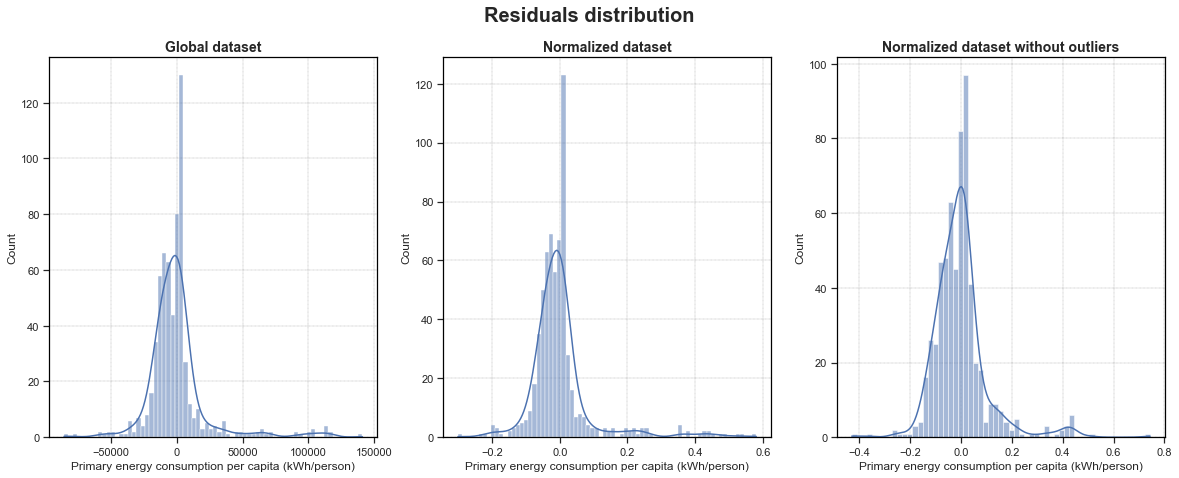

In [47]:
LR_model_pred = LR_model.predict(X_pe_test)
LR_model_nor_pred = LR_model_nor.predict(X_nor_pe_test)
LR_model_nor_wo_pred = LR_model_nor_wo.predict(X_nor_pe_wo_test)

residuals = y_pe_test - LR_model_pred
residuals_nor = y_nor_pe_test - LR_model_nor_pred
residuals_nor_wo = y_nor_pe_wo_test - LR_model_nor_wo_pred

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
sns.histplot(residuals, ax=ax[0], kde=True).set_title(label='Global dataset', fontdict={'fontsize': 14, 'fontweight': 'bold'})
sns.histplot(residuals_nor, ax=ax[1], kde=True).set_title(label='Normalized dataset', fontdict={'fontsize': 14, 'fontweight': 'bold'})
sns.histplot(residuals_nor_wo, ax=ax[2], kde=True).set_title(label='Normalized dataset without outliers', fontdict={'fontsize': 14, 'fontweight': 'bold'})
fig.suptitle('Residuals distribution', fontsize=20, fontweight='bold')
plt.savefig('../img/residuals_distribution.png', dpi=200, bbox_inches='tight')
